# Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import urllib
import itertools
import random, os, glob
import zipfile
import shutil
import h5py
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

# Import Dataset

In [ ]:
dir_path = "/content/garbage classification/Garbage classification"

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
target_size = (224, 224)
waste_labels = {"cardboard":0, "glass":1, "metal":2, "paper":3, "plastic":4}

In [ ]:
def load_dataset(path):
    x = []
    labels = []
    image_paths = sorted(list(paths.list_images(path)))
    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)
        x.append(img)
        label = image_path.split(os.path.sep)[-2]
        labels.append(waste_labels[label])
    x, labels = shuffle(x, labels, random_state=42)
    input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
    print("X shape:", np.array(x).shape)
    print("Number of Labels:", len(np.unique(labels)), ", Number of Observations:", len(labels))
    print("Input Shape:", input_shape)
    return x, labels, input_shape

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rhezapandyaa","key":"5f1b2cc3b2ace1356df80a8b4e616896"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'asdasdasasdas/garbage-classification'

 89% 73.0M/82.0M [00:01<00:00, 77.3MB/s]
100% 82.0M/82.0M [00:01<00:00, 77.8MB/s]


In [ ]:
dataset_zip = zipfile.ZipFile('garbage-classification.zip','r')
dataset_zip.extractall()
dataset_zip.close()

In [ ]:
shutil.rmtree("/content/garbage classification/Garbage classification/trash")

In [ ]:
x, labels, input_shape = load_dataset(dir_path)

X shape: (2390, 224, 224, 3)
Number of Labels: 5 , Number of Observations: 2390
Input Shape: (224, 224, 3)


# Visulization Image

In [ ]:
def visualize_img(image_batch, labels, num_of_img):
    plt.figure(figsize=(10, 10))
    for n in range(num_of_img):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=len(np.unique(labels)))[n] == 1][0].title())
        plt.axis("off")

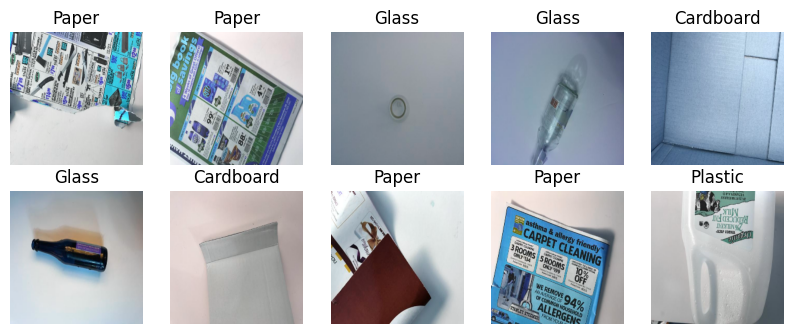

In [ ]:
  visualize_img(x, labels, 10)

In [ ]:
def CNN_data_preparation():
    train = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.1,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1
    )
    test = ImageDataGenerator(rescale=1./255, validation_split=0.1)
    train_generator = train.flow_from_directory(
        directory=dir_path,
        target_size=(target_size),
        class_mode="categorical",
        subset="training"
    )
    test_generator = test.flow_from_directory(
        directory=dir_path,
        target_size=(target_size),
        batch_size=251,
        class_mode="categorical",
        subset="validation"
    )

    return train_generator, test_generator

In [ ]:
train_generator, test_generator = CNN_data_preparation()

Found 2152 images belonging to 5 classes.
Found 238 images belonging to 5 classes.


# Modeling

In [ ]:
# !pip install tensorflow-model-optimization

In [ ]:
# import tensorflow_model_optimization as tfmot

In [ ]:
def CNN_create_and_fit_model(train_generator, test_generator, summary=True, fit=True, epochs=100):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=input_shape, activation="relu"))
    model.add(MaxPooling2D(pool_size=2, strides=(2, 2)))
    model.add(Dropout(rate=0.25))  # Add dropout after pooling

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2, strides=(2, 2)))
    model.add(Dropout(rate=0.25))  # Add dropout after pooling

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2, strides=(2, 2)))
    model.add(Dropout(rate=0.25))  # Add dropout after pooling

    model.add(Flatten())

    model.add(Dense(units=256, activation="relu"))
    model.add(Dropout(rate=0.5))  # Increase dropout rate

    model.add(Dense(units=128, activation="relu"))
    model.add(Dropout(rate=0.5))  # Increase dropout rate

    model.add(Dense(units=5, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]  # Remove precision and recall metrics for simplicity
    )

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=35, verbose=1, mode="min"),  # Reduce patience
        ModelCheckpoint(
            filepath="mymodel.h5",
            monitor="val_loss",
            mode="min",
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        )
    ]

    if summary:
        model.summary()

    if fit:
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=test_generator,
            callbacks=callbacks
        )

    return model, history

In [ ]:
model, history = CNN_create_and_fit_model(train_generator, test_generator, summary=True, fit=True, epochs=100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 56, 56, 64)       

# Evaluation

In [ ]:
print(list(waste_labels.keys()))

['cardboard', 'glass', 'metal', 'paper', 'plastic']


In [ ]:
def CNN_model_evaluate(model):
    loss, accuracy = model.evaluate(test_generator, batch_size=32) # add precision, recall,
    print("Test Accuracy: %.2f" % (100 * accuracy))
    print("Test Loss: %.2f" % (100 * loss))
    # print("Test Precision: %.2f" % (100 * precision))
    # print("Test Recall: %.2f" % (100 * recall))

    X_test, y_test = test_generator.next()
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    target_names = list(waste_labels.keys())
    print(classification_report(y_test, y_pred, target_names=target_names))

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], color="r", label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], color="b", label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.ylim([min(plt.ylim()), 1])
    plt.title("Training and Validation Accuracy", fontsize=16)

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], color="r", label="Training Loss")
    plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.ylim([0, max(plt.ylim())])
    plt.title("Training and Validation Loss", fontsize=16)

    return y_test, y_pred

1/1 [==============================] - 1s 1s/step - loss: 0.7841 - accuracy: 0.7437
Test Accuracy: 74.37
Test Loss: 78.41
8/8 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

   cardboard       1.00      0.80      0.89        40
       glass       0.62      0.72      0.67        50
       metal       0.67      0.78      0.72        41
       paper       0.92      0.78      0.84        59
     plastic       0.62      0.65      0.63        48

    accuracy                           0.74       238
   macro avg       0.77      0.75      0.75       238
weighted avg       0.77      0.74      0.75       238



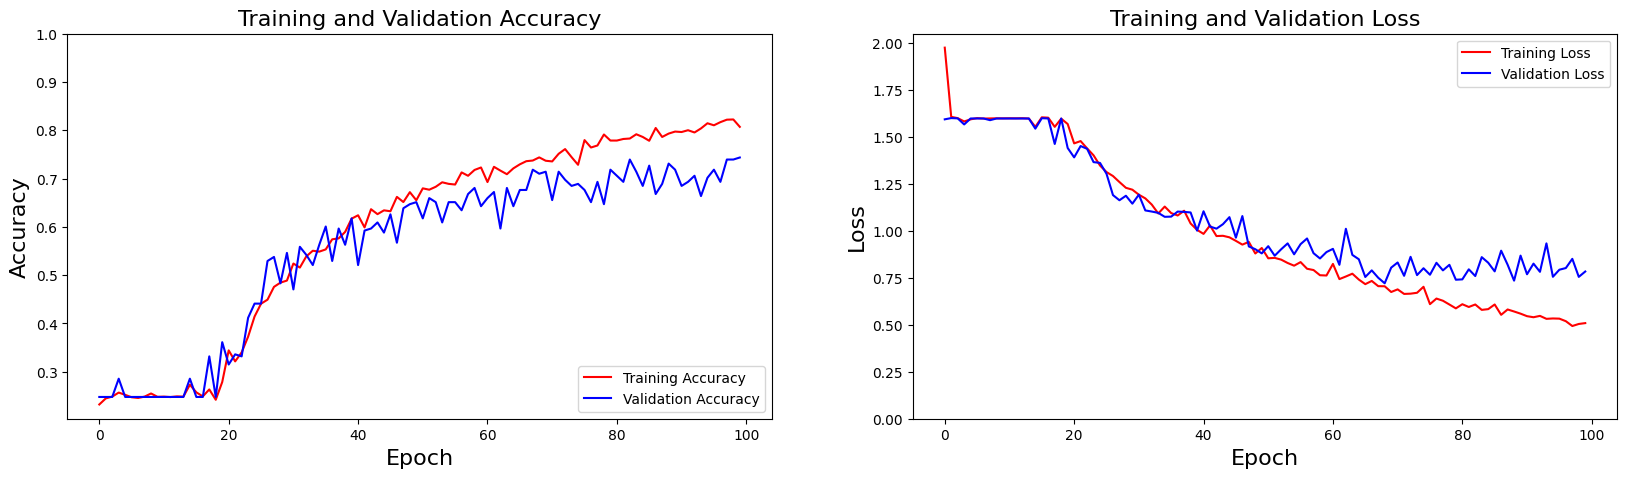

In [ ]:
y_test, y_pred = CNN_model_evaluate(model)

# Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.OrRd):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True Labels", fontweight="bold")
    plt.xlabel("Predicted Labels", fontweight="bold")

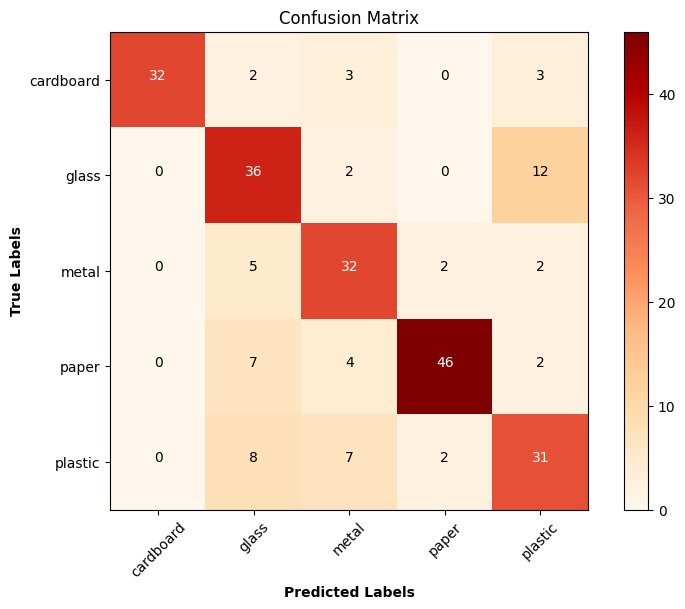

In [ ]:
plot_confusion_matrix(cm, waste_labels.keys())

# Model Testing

In [ ]:
def CNN_model_testing(path):
    img = image.load_img(path, target_size=target_size)
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img) / 255.0
    p = model.predict(img.reshape(1, 224, 224, 3))
    predicted_class = np.argmax(p[0])
    return img, p, predicted_class

In [ ]:
img, p, predicted_class = CNN_model_testing("/content/Garbage classification/Garbage classification/paper/paper5.jpg")

1/1 [==============================] - 0s 45ms/step


In [ ]:
waste_labels = {0:"cardboard", 1:"glass", 2:"metal", 3:"paper", 4:"plastic", 5:"trash"}
def plot_model_testing(img, p, predicted_class):
    plt.axis("off")
    plt.imshow(img.squeeze())
    if int(predicted_class) in (0, 3):
        anor = "Organik"
    else:
        anor = "Anorganik"
    plt.title(
        "Maximum Probability: "
        + str(np.max(p[0], axis=-1))
        + "\n"
        + "Predicted Class: "
        + str(waste_labels[predicted_class])
        + "\n"
        + str(anor)
    )
    plt.imshow(img)

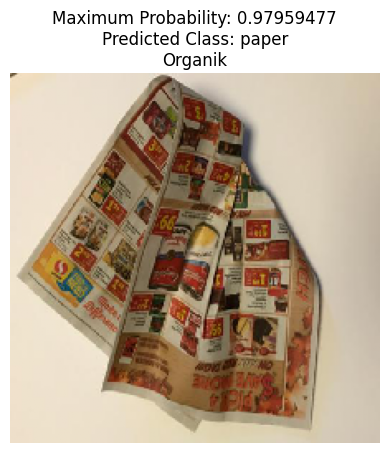

In [ ]:
plot_model_testing(img, p, predicted_class)

In [ ]:
model.save('sortify_model.h5')